# TEST CON FEATURES DEL PSD

# Generar 'X' e 'y' para todos los experimentos
<p>Como datos para las X se toma la media de los 17 canales de:</p>
<ul>
    <li>X_1: PSD de la banda delta (1~4Hz)</li>
    <li>X_2: PSD de la banda theta (4~8Hz)</li>
    <li>X_3: PSD de la banda alpha (8~14Hz)</li>
    <li>X_4: PSD de la banda beta (14~31Hz)</li>
    <li>X_5: PSD de la banda gamma (31~50 Hz)</li>
</ul>

In [1]:
import mne
from mne.externals.pymatreader import read_mat

import matplotlib
import matplotlib.pyplot as plt

import numpy as np

from sklearn.preprocessing import MinMaxScaler

In [2]:
labels = {
    'leve': 0,
    'moderada': 1,
    'severa': 2
}

def parse_y(y, lim_leve=0.075, lim_moderada=0.15):
    def classify(val):
        if (val <= lim_leve):
            return labels['leve']
        if (val <= lim_moderada):
            return labels['moderada']
        return labels['severa']
    
    len_y = len(y)
    classified = np.zeros(len_y, dtype=int)
    
    for i in range(len_y):
        classified[i] = classify(y[i])
        
    return classified

In [3]:
# Las que mejores graficas tienen
# features_files = ['4_20151105_noon.mat', '4_20151107_noon.mat', '5_20141108_noon.mat','12_20150928_noon.mat','14_20151014_night.mat', '18_20150926_noon.mat', '21_20151016_noon.mat']

# features_files = ['4_20151105_noon.mat', '5_20141108_noon.mat', '21_20151016_noon.mat']

features_files = ['1_20151124_noon_2.csv', '2_20151106_noon.csv', '3_20151024_noon.csv','4_20151105_noon.csv', '4_20151107_noon.csv',
            '5_20141108_noon.csv', '5_20151012_night.csv', '6_20151121_noon.csv','7_20151015_night.csv', '8_20151022_noon.csv', 
            '9_20151017_night.csv', '10_20151125_noon.csv', '11_20151024_night.csv', '12_20150928_noon.csv', '13_20150929_noon.csv',
            '14_20151014_night.csv','15_20151126_night.csv', '16_20151128_night.csv', '17_20150925_noon.csv', '18_20150926_noon.csv',
            '19_20151114_noon.csv', '20_20151129_night.csv', '21_20151016_noon.csv']

# features_files = ['21_20151016_noon.csv']

X_all = {} # psd
X_all_eog = {} # psd + eog
y_all = {} # datos perclos raw
y_all_class = {} # datos parseados a su clase

for experiment in features_files:
    
    ''' EOG parpadeos por epoch'''
    mat_data = read_mat(f'./SEED-VIG/Raw_Data/{experiment[:-4]}.mat')
    
    sfreq = mat_data['EOG']['eog_config']['current_sample_rate']
    samples = mat_data['EOG']['eog_h']*1e-6 
    samples = np.vstack((samples, mat_data['EOG']['eog_v']*1e-6))

    ch_names = ['EOG_H', 'EOG_V']
    ch_types = ["eog"]*len(ch_names)

    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

    info.set_montage('standard_1020')
    
    raw = mne.io.RawArray(samples, info, verbose=False)
    
    # Busqueda del treshold para el parpadeo
    # En los 5 primeros segundos del experimento, buscamos el percentil 2.5 y calculamos su valor absoluto como threshold para detectar parpadeos
    threshold = abs(np.percentile(raw.get_data()[1][:5*1000], 2.5))
    
    blinks = mne.preprocessing.find_eog_events(raw, filter_length='10s', thresh=threshold, verbose=False)
    blinks = blinks.T[0]
    
    n_samples = 885
    dur_sample = 8 # segs
    len_sample = 8*125
    
    blinks_per_sample = []
    for i in range(n_samples):
        blinks_per_sample.append([])
        
    for val in blinks:
        blinks_per_sample[val//len_sample].append(val)
    
    n_blinks_per_sample = [0]*n_samples
        
    for i in range(885):
        n_blinks_per_sample[i] = len(blinks_per_sample[i])
        
    scaler = MinMaxScaler(feature_range=(0, 1))
    n_blinks_per_sample = np.array(n_blinks_per_sample)
    n_blinks_per_sample = scaler.fit_transform(n_blinks_per_sample.reshape(-1,1))
    
    
    ''' PSD '''
    mat_data = read_mat(f'./SEED-VIG/EEG_Feature_5Bands/{experiment[:-4]}.mat')
    perclos_data = read_mat(f'./SEED-VIG/perclos_labels/{experiment[:-4]}.mat')
    y = np.array(perclos_data['perclos'])

    n_channels = 17
    psd_data = mat_data['psd_movingAve']
    perclos = []
    psd_delta = []
    psd_theta = []
    psd_alpha = []
    psd_beta = []
    psd_gamma = []
    start = 0
    end = 885
    for t in range(start, end):
        vals= np.zeros(5)

        for i in range(n_channels):
            vals[0] += psd_data[i][t][0]
            vals[1] += psd_data[i][t][1]
            vals[2] += psd_data[i][t][2]
            vals[3] += psd_data[i][t][3]
            vals[4] += psd_data[i][t][4]
        vals /= 17

        perclos.append(y[t])
        psd_delta.append(vals[0])
        psd_theta.append(vals[1])
        psd_alpha.append(vals[2])
        psd_beta.append(vals[3])
        psd_gamma.append(vals[4])

    
    scaler = MinMaxScaler(feature_range=(0, 1))
    psd_delta = np.array(psd_delta)
    psd_delta = scaler.fit_transform(psd_delta.reshape(-1,1))

    scaler = MinMaxScaler(feature_range=(0, 1))
    psd_theta = np.array(psd_theta)
    psd_theta = scaler.fit_transform(psd_theta.reshape(-1,1))

    scaler = MinMaxScaler(feature_range=(0, 1))
    psd_alpha = np.array(psd_alpha)
    psd_alpha = scaler.fit_transform(psd_alpha.reshape(-1,1))

    scaler = MinMaxScaler(feature_range=(0, 1))
    psd_beta = np.array(psd_beta)
    psd_beta = scaler.fit_transform(psd_beta.reshape(-1,1))
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    psd_gamma = np.array(psd_gamma)
    psd_gamma = scaler.fit_transform(psd_gamma.reshape(-1,1))

    X = psd_delta
    X = np.hstack((X, psd_theta))
    X = np.hstack((X, psd_alpha))
    X = np.hstack((X, psd_beta))
    ''' DESCOMENTAR PARA USAR PSD DE GAMMA '''
    X = np.hstack((X, psd_gamma))
    
    X_all[f'{experiment[:-4]}'] = X # guardamos los psd
    
    X = np.hstack((X, n_blinks_per_sample))
    
    X_all_eog[f'{experiment[:-4]}'] = X # guardamos psd + eog
    
    y_all[f'{experiment[:-4]}'] = y # guardamos perclos raw
    
    ''' TODO, escoger los valores de perclos a partir de percentiles con maximos y minimos'''
    y_all_class[f'{experiment[:-4]}'] = parse_y(y, lim_leve=0.15, lim_moderada=0.30) # guardamos y clasificada
    
print(f'Generados los diccionarios X_all e y_all')

Generados los diccionarios X_all e y_all


In [77]:
from read import read_features

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [78]:
# features_files = ['1_20151124_noon_2.csv', '2_20151106_noon.csv', '3_20151024_noon.csv','4_20151105_noon.csv', '4_20151107_noon.csv',
#             '5_20141108_noon.csv', '5_20151012_night.csv', '6_20151121_noon.csv','7_20151015_night.csv', '8_20151022_noon.csv', 
#             '9_20151017_night.csv', '10_20151125_noon.csv', '11_20151024_night.csv', '12_20150928_noon.csv', '13_20150929_noon.csv',
#             '14_20151014_night.csv','15_20151126_night.csv', '16_20151128_night.csv', '17_20150925_noon.csv', '18_20150926_noon.csv',
#             '19_20151114_noon.csv', '20_20151129_night.csv', '21_20151016_noon.csv']

features_files = ['4_20151105_noon.mat', '4_20151107_noon.mat', '5_20141108_noon.mat','12_20150928_noon.mat','14_20151014_night.mat', '18_20150926_noon.mat', '21_20151016_noon.mat']

In [4]:
print(X_all_eog['21_20151016_noon'].shape)

for key in X_all:
    print(key)

(885, 6)
1_20151124_noon_2
2_20151106_noon
3_20151024_noon
4_20151105_noon
4_20151107_noon
5_20141108_noon
5_20151012_night
6_20151121_noon
7_20151015_night
8_20151022_noon
9_20151017_night
10_20151125_noon
11_20151024_night
12_20150928_noon
13_20150929_noon
14_20151014_night
15_20151126_night
16_20151128_night
17_20150925_noon
18_20150926_noon
19_20151114_noon
20_20151129_night
21_20151016_noon


# Busqueda de hyperparametros y muestra de los resultados

## Funciones para la busqueda y el plot

In [5]:
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_confusion_matrix

from scipy.stats import uniform, randint, loguniform, gamma

def find_and_test_best_model_class(X, y, model, space, cv=10, n_iter=100, scoring=None, conf_mat=False):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    
    search = RandomizedSearchCV(model, space, n_iter=n_iter, scoring=scoring, n_jobs=-1, cv=cv, random_state=42)
    result = search.fit(X_train, y_train)
    
    print(f"Best Model:")
    print(f"\tScore: {result.best_score_:.4f}")
    print(f"\tHyperparameters: {result.best_params_}")
    
    print('\nResults with X_test:')
    best_model = result.best_estimator_
    final_predictions = best_model.predict(X_test)
    
    #TODO sklearn.metrics.classification_report ofrece los siguientes parametros y alguna cosilla mas, puede ser interesante ???
    print(f"\tPrecision: {precision_score(y_test, final_predictions, average='macro', zero_division=1):.4f}")
    print(f"\tRecall: {recall_score(y_test, final_predictions, average='macro', zero_division=1):.4f}")
    print(f"\tf1: {f1_score(y_test, final_predictions, average='macro', zero_division=1):.4f}")
    
    ''' PARA MOSTRAR LA MATRIZ DE CONFUSION HAY QUE PASAR EL PARAMETRO conf_mat=True '''
    if (conf_mat):
        print(f'Matriz de confusión para X_test')
        plot_confusion_matrix(best_model, X_test, y_test, display_labels=['leve', 'moderara', 'severa'])
        plt.show()

        print(f'Matriz de confusión para X completo')
        plot_confusion_matrix(best_model, X, y, display_labels=['leve', 'moderara', 'severa'])
        plt.show()
    
    return best_model

def map_2_colors(y, labels):
    label_2_color = {
        0: 'green',
        1: 'orange',
        2: 'red'
    }
    
    cmap = []
    for i in range(len(y)):
        cmap.append(label_2_color[y[i]])
    return cmap

def plot_results_class(X, y, model, lim_leve_moderada, lim_moderada_severa):
    plt.figure(figsize=(20, 8))
    plt.axhspan(0, lim_leve_moderada, facecolor='green', alpha=0.2, label="Somnolencia leve")
    plt.axhspan(lim_leve_moderada, lim_moderada_severa, facecolor='orange', alpha=0.2, label="Somnolencia moderada")
    plt.axhspan(lim_moderada_severa, 1, facecolor='red', alpha=0.2, label="Somnolencia severa")
    plt.plot(y, c='k', alpha=0.6)
    colors = map_2_colors(model.predict(X), labels)
    plt.scatter(range(len(y)), y, c=colors)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.show()

## LDA

In [6]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

Experiment: 21_20151016_noon
Best Model:
	Score: 0.7349
	Hyperparameters: {'solver': 'svd', 'n_components': None}

Results with X_test:
	Precision: 0.8741
	Recall: 0.5308
	f1: 0.5203


c:\users\usuario\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:289: UserWarning: The total space of parameters 12 is smaller than n_iter=50. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


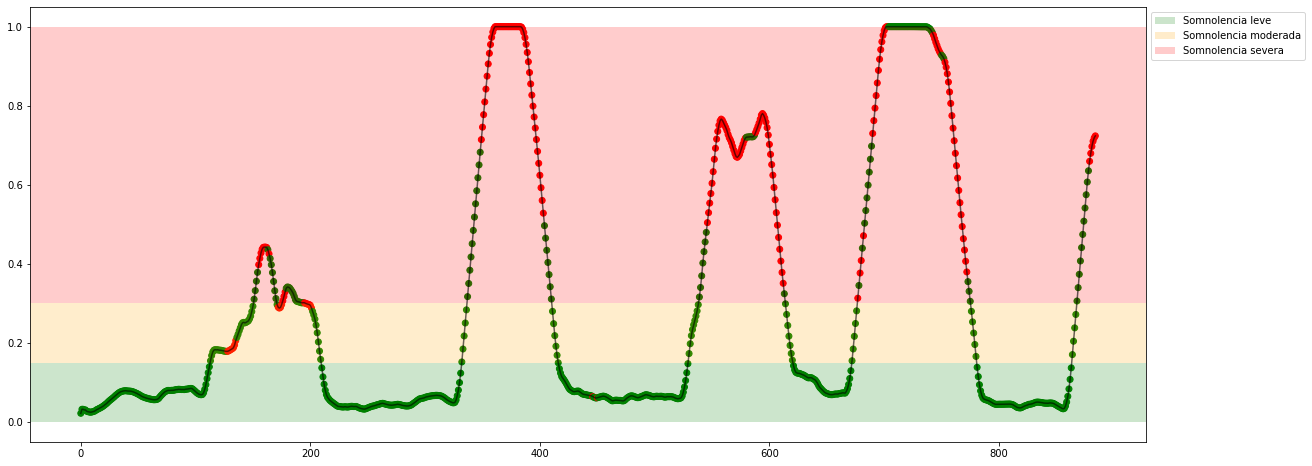

In [28]:
key = '21_20151016_noon'

# for key in X_all:
print(f"Experiment: {key}")

model = LinearDiscriminantAnalysis()

cv = StratifiedShuffleSplit(n_splits=10, test_size=0.25, random_state=42)

space = dict()
space['solver'] = ['svd', 'lsqr', 'eigen']
space['n_components'] = [None] + np.array(range(0, 2+1)).tolist()


best_model = find_and_test_best_model_class(X_all_eog[key], y_all_class[key], model, space, cv, 50)

lim_leve_moderada = 0.15
lim_moderada_severa = 0.30
plot_results_class(X_all_eog[key], y_all[key], best_model, lim_leve_moderada, lim_moderada_severa)

Experiment: 4_20151105_noon


c:\users\usuario\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:289: UserWarning: The total space of parameters 12 is smaller than n_iter=100. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best Model:
	Score: 0.6488
	Hyperparameters: {'solver': 'svd', 'n_components': None}

Results with X_test:
	Precision: 0.6633
	Recall: 0.6889
	f1: 0.6738


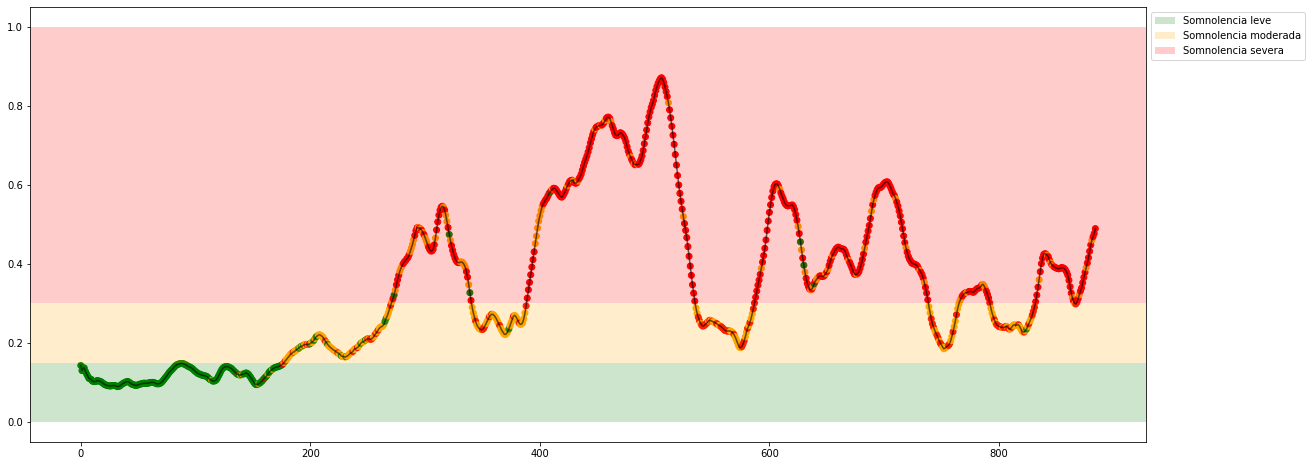

Experiment: 4_20151107_noon


c:\users\usuario\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:289: UserWarning: The total space of parameters 12 is smaller than n_iter=100. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best Model:
	Score: 0.7283
	Hyperparameters: {'solver': 'svd', 'n_components': None}

Results with X_test:
	Precision: 0.5492
	Recall: 0.5276
	f1: 0.5370


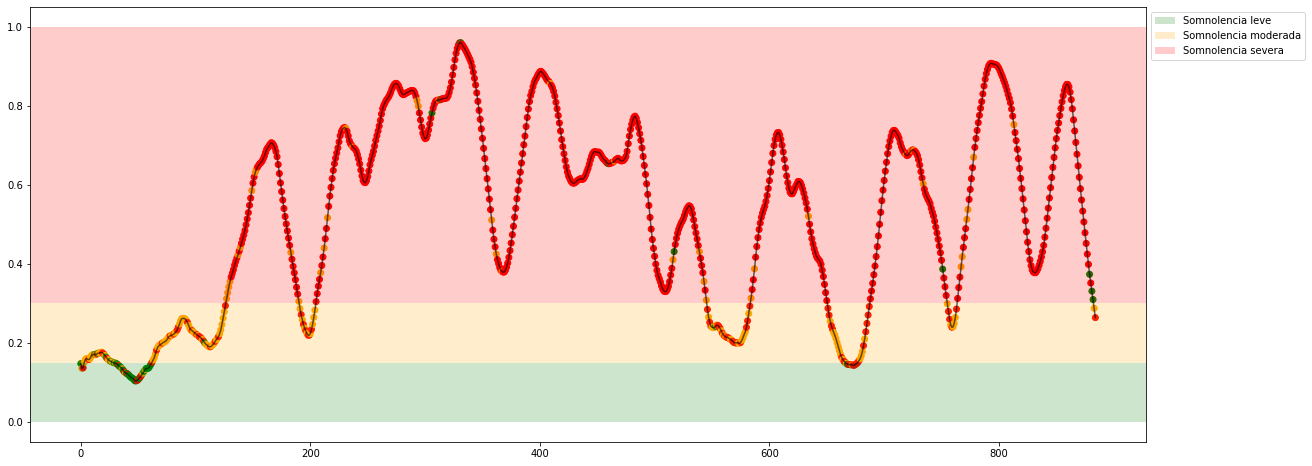

Experiment: 5_20141108_noon


c:\users\usuario\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:289: UserWarning: The total space of parameters 12 is smaller than n_iter=100. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best Model:
	Score: 0.5861
	Hyperparameters: {'solver': 'svd', 'n_components': None}

Results with X_test:
	Precision: 0.5473
	Recall: 0.5574
	f1: 0.5510


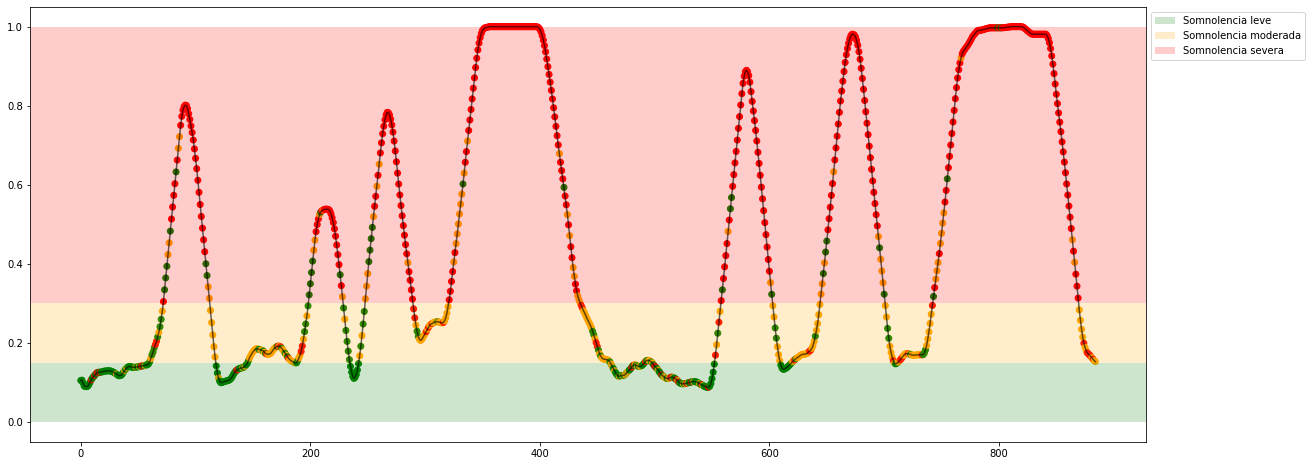

Experiment: 12_20150928_noon


c:\users\usuario\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:289: UserWarning: The total space of parameters 12 is smaller than n_iter=100. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best Model:
	Score: 0.7301
	Hyperparameters: {'solver': 'svd', 'n_components': None}

Results with X_test:
	Precision: 0.5238
	Recall: 0.5234
	f1: 0.5213


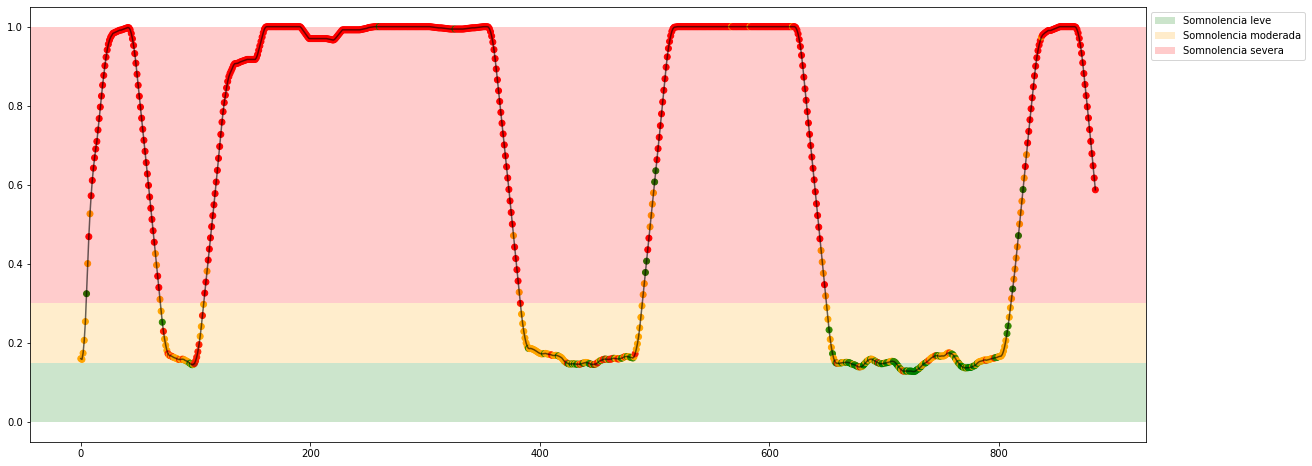

Experiment: 14_20151014_night


c:\users\usuario\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:289: UserWarning: The total space of parameters 12 is smaller than n_iter=100. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best Model:
	Score: 0.8187
	Hyperparameters: {'solver': 'lsqr', 'n_components': None}

Results with X_test:
	Precision: 0.5455
	Recall: 0.5404
	f1: 0.5425


c:\users\usuario\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [0.81807229 0.8186747  0.8186747  0.81807229 0.8186747  0.8186747
 0.81807229 0.8186747  0.8186747         nan        nan        nan]
  category=UserWarning


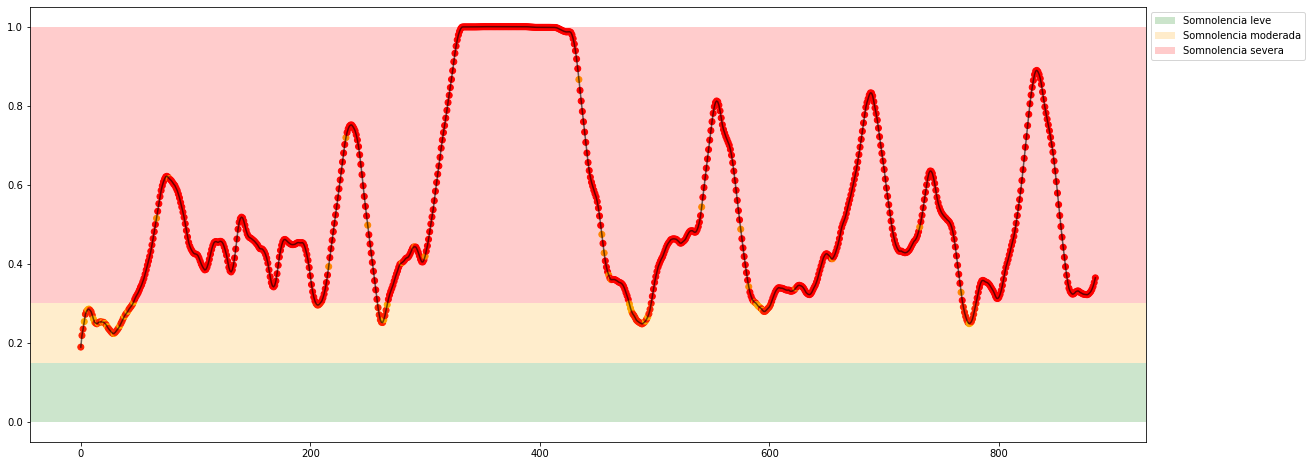

Experiment: 18_20150926_noon


c:\users\usuario\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:289: UserWarning: The total space of parameters 12 is smaller than n_iter=100. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best Model:
	Score: 0.6542
	Hyperparameters: {'solver': 'lsqr', 'n_components': None}

Results with X_test:
	Precision: 0.5000
	Recall: 0.5148
	f1: 0.5027


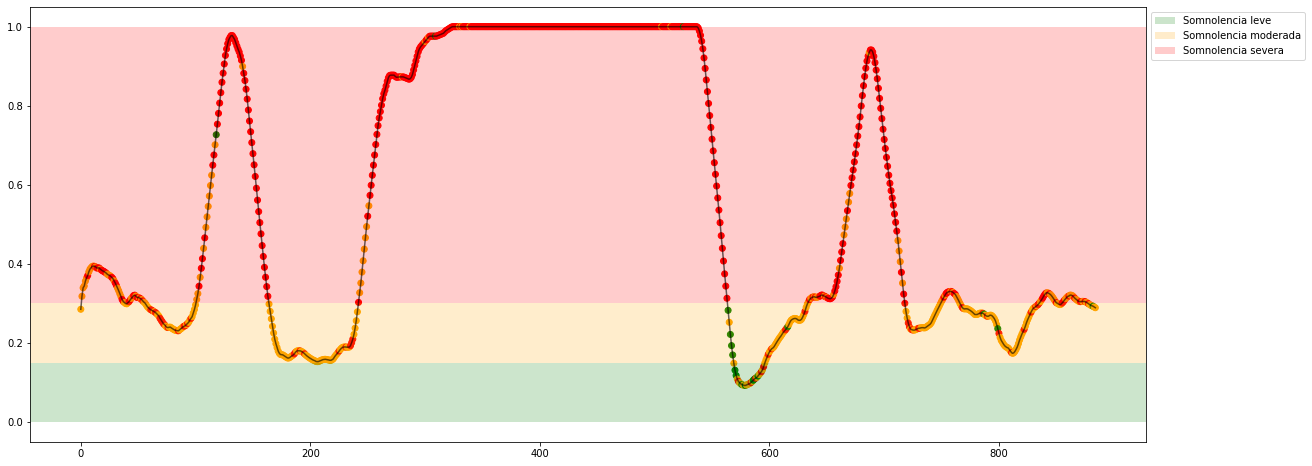

Experiment: 21_20151016_noon


c:\users\usuario\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:289: UserWarning: The total space of parameters 12 is smaller than n_iter=100. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best Model:
	Score: 0.6265
	Hyperparameters: {'solver': 'svd', 'n_components': None}

Results with X_test:
	Precision: 0.5766
	Recall: 0.5510
	f1: 0.5592


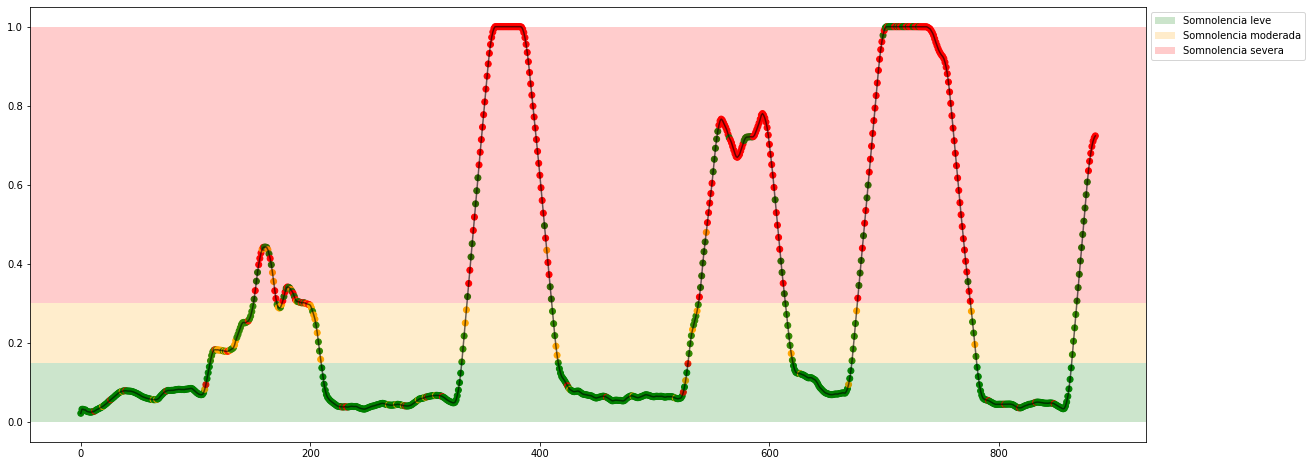

In [83]:
for file in features_files:
    
    X, y = read_features(f'./features/{file[:-4]}.csv')
    #X, y = read_features(file, features=[0, 1])
    y_class = parse_y(y, lim_leve=0.15, lim_moderada=0.30)

    scaler = MinMaxScaler(feature_range=(0, 1))
    X_minmax = scaler.fit_transform(X)

    scaler = StandardScaler()
    X_standar = scaler.fit_transform(X)

    key = file[:-4]
    print(f"Experiment: {key}")
    model = LinearDiscriminantAnalysis()

    cv = StratifiedShuffleSplit(n_splits=10, test_size=0.25, random_state=42)

    space = dict()
    space['solver'] = ['svd', 'lsqr', 'eigen']
    space['n_components'] = [None] + np.array(range(0, 2+1)).tolist()

    best_model = find_and_test_best_model_class(X_minmax, y_class, model, space, cv, 100)

    lim_leve_moderada = 0.15
    lim_moderada_severa = 0.30
    plot_results_class(X_minmax, y, best_model, lim_leve_moderada, lim_moderada_severa)

## Quadratic Discriminant Analysis

In [32]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

Experiment: 21_20151016_noon
Best Model:
	Score: 0.6922
	Hyperparameters: {'reg_param': 0.027610585618011996, 'tol': 0.0008254614284548342}

Results with X_test:
	Precision: 0.8774
	Recall: 0.4872
	f1: 0.4795
[0.52941176 0.10859729 0.36199095]


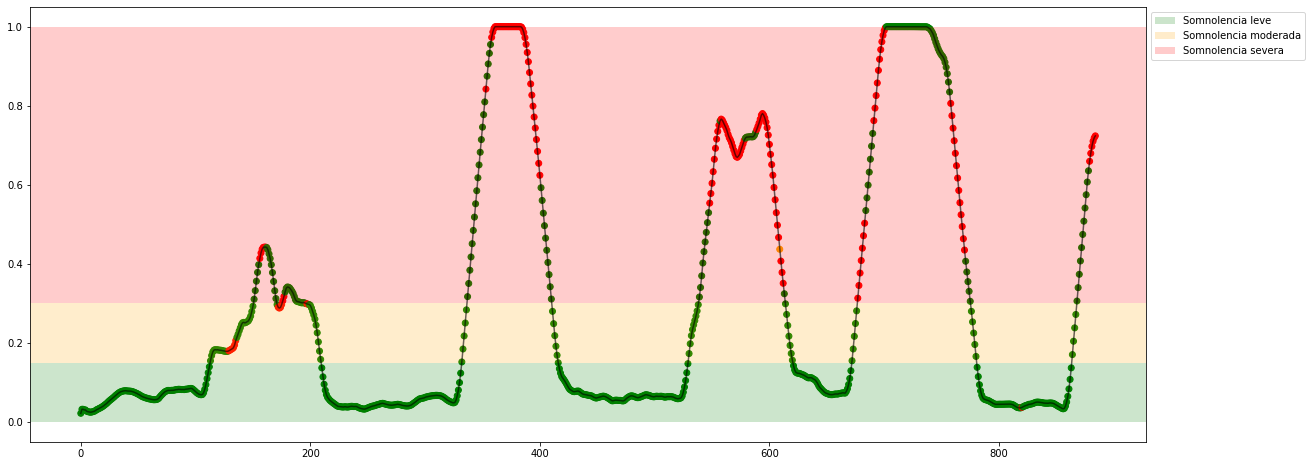

In [76]:
key = '21_20151016_noon'

# for key in X_all:
print(f"Experiment: {key}")

model = QuadraticDiscriminantAnalysis()

cv = StratifiedShuffleSplit(n_splits=10, test_size=0.25, random_state=42)

space = dict()
space['tol'] = uniform(1.0e-5, 1.0e-3)
space['reg_param'] = uniform(0, 5)


best_model = find_and_test_best_model_class(X_all_eog[key], y_all_class[key], model, space, cv, 100)
print(f'{best_model.priors_}')

lim_leve_moderada = 0.15
lim_moderada_severa = 0.30
plot_results_class(X_all_eog[key], y_all[key], best_model, lim_leve_moderada, lim_moderada_severa)

Experiment: 4_20151105_noon


c:\users\usuario\appdata\local\programs\python\python37\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Best Model:
	Score: 0.5681
	Hyperparameters: {'reg_param': 0.9091248360355031, 'tol': 0.00019340450985343383}

Results with X_test:
	Precision: 0.5599
	Recall: 0.6075
	f1: 0.5601


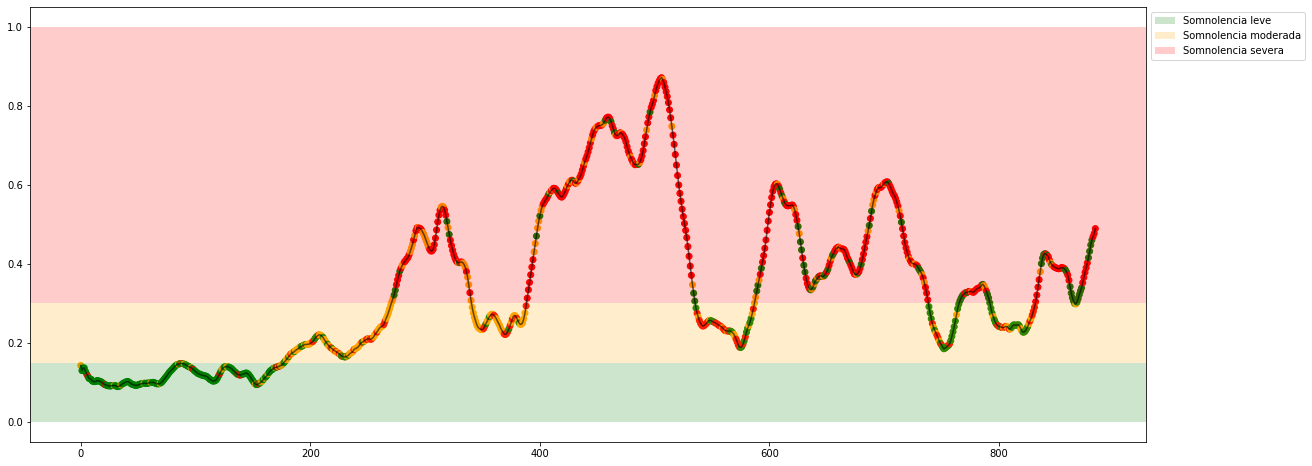

Experiment: 4_20151107_noon


KeyboardInterrupt: 

In [82]:
for file in features_files:
    
    X, y = read_features(f'./features/{file[:-4]}.csv')
    #X, y = read_features(file, features=[0, 1])
    y_class = parse_y(y, lim_leve=0.15, lim_moderada=0.30)

    scaler = MinMaxScaler(feature_range=(0, 1))
    X_minmax = scaler.fit_transform(X)

    scaler = StandardScaler()
    X_standar = scaler.fit_transform(X)

    key = file[:-4]
    print(f"Experiment: {key}")
    model = QuadraticDiscriminantAnalysis()

    cv = StratifiedShuffleSplit(n_splits=10, test_size=0.25, random_state=42)

    space = dict()
    space['tol'] = uniform(1.0e-5, 1.0e-3)
    space['reg_param'] = uniform(0, 5)

    best_model = find_and_test_best_model_class(X_standar, y_class, model, space, cv, 100)

    lim_leve_moderada = 0.15
    lim_moderada_severa = 0.30
    plot_results_class(X_standar, y, best_model, lim_leve_moderada, lim_moderada_severa)